# import 

In [7]:
from __future__ import division

from scipy.spatial.distance import pdist, squareform

from numpy import linalg as LA

from scipy.linalg import eigh, eig 

import numpy as np 
import numpy 
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt 
from cvxopt import matrix 
import cvxopt 
import numpy 
import numpy as np
from sys import stdout
from sklearn.metrics import pairwise_kernels
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
%matplotlib inline 

# 参考 https://github.com/emanuele/kernel_two_sample_test/blob/master/kernel_two_sample_test.py 

1. 实现MMD统计量的计算，数据与核函数自选
2. 实现基于MMD的假设检验过程

##  定义函数  

unbiased MMD统计量的计算

In [4]:
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


In [5]:
def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


In [6]:
def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value


## 跑code on two Gaussians (8.1 )
 

### 定义样本 X Y 和分布 p, q 

 
两样本检测问题: 给定两个未知分布 p 和 q抽取的样本, 评估p,q是否相同。样本分别为 $X=\{x_1, ..., x_m\}, Y=\{y_1, ..., y_n\}$

这个例子：假设p,q 都是高斯分布。 采用bootstrap统计 


In [11]:
np.random.seed(0) 
m = 250 # 样本数  p 
n = 250 # 样本数 q
d = 2  #  dim

假设p,q两个高斯分布的均值不同，协方差相同

In [13]:
sigma2X = np.eye(d)
muX = np.zeros(d)

sigma2Y = np.eye(d)
muY = np.ones(d)
#    muY = np.zeros(d)

In [17]:
X = np.random.multivariate_normal(mean=muX, cov=sigma2X, size=m)
Y = np.random.multivariate_normal(mean=muY, cov=sigma2Y, size=n)
print (X.shape) , print(Y.shape)

(250, 2)
(250, 2)


(None, None)

### 画图 samples X Y 

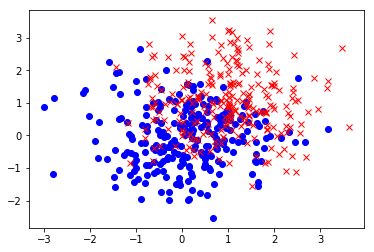

In [18]:
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.plot(Y[:, 0], Y[:, 1], 'rx')
        #plt.show()

In [19]:
sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
print(sigma2)

4.077820723559476


In [20]:
kernel_function='rbf' # kernel 用 gaussian 

### 计算 MMD  用无偏估计 

\begin{equation}
\begin{aligned}
\mathcal{M M D}_u\left(\mathbf{X} , \mathbf{Y}\right) &=\left(\frac{1}{m\left(m-1\right)} \sum_{i=1}^{m} \sum_{j=1,j\ne i}^{m} k\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)+\frac{1}{n\left(n-1\right)} \sum_{i=1}^{n} \sum_{j=1,j \ne i }^{n} k\left(\mathbf{y}_{i}, \mathbf{y}_{j}\right)\right.\\
&\left.-\frac{2}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} k\left(\mathbf{x}_{i}, \mathbf{y}_{j} \right)\right)^{\frac{1}{2}}
\end{aligned}
\end{equation}

In [44]:
XY = np.vstack([X, Y])
K = pairwise_kernels(XY, metric=kernel_function, gamma=1.0/sigma2)
#print ( K.shape  )
      
mmd2u = MMD2u(K, m, n) # 公式(3 )
mmd2u 


0.2147558149807104

### 这里需要用到 Bootstrap Hypothesis Testing

零假设 必须含有等号， 这里，零假设 null hypothesis 假设两个分布相同. 

计算p-vlaue, 也就是在零假设**成立**的条件下, 出现 现状 或 更差 的情况的概率。  

In [45]:
iterations = 10000  # bootstrap的重复抽样次数 

Bootstrap Hypothesis Testing for two sample problem

步骤 ：     
    
1. 从$Z= X\cup Y $ 中有放回抽取$n+m$个样本
2. 把top $m$个样本当成"新"的$X^*$, 后 $n$个样本当成"新"的$Y^*$, 组成新的 $Z^*$
3.  在$Z^*$计算 $t(Z^* )$ (这里是$MMD$) 
4.  重复 1-3 $B$ 次 (一般$10000$), 并记录每次的t 
    
最后近似 $ASL$(Achieved significance level):
 
 \begin{equation}
    \widehat{ASL}=\#\{ t(Z^*) \ge t(Z) \}/B
\end{equation}

$\#$ 意为有多少个违反 零假设的证据出现

In [40]:
mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=True ,) 
                                            

len (mmd2u_null)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000



10000

### 计算p-value 

In [41]:
#print("mmd2u_null is ", mmd2u_null)
#x1 = ( mmd2u_null > mmd2u).sum() #  
#print ( "x1: ",x1)
     
p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
print("p_value is ", p_value)
     
#if verbose:
print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))


p_value is  0.0001
p-value ~= 0.0001 	 (resolution : 0.0001)


Text(0.5,1,'$MMD^2_u$: null-distribution and observed value. $p$-value=0.0001')

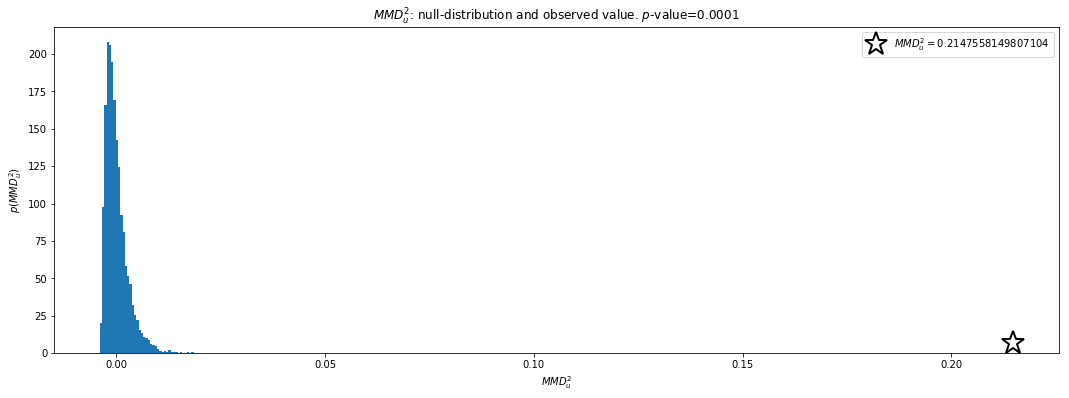

In [42]:
plt.figure(figsize=(18, 6))
prob, bins, patches = plt.hist(mmd2u_null, bins=50, normed=True)
plt.plot(mmd2u, prob.max()/30, 'w*', markersize=24, markeredgecolor='k',
             markeredgewidth=2, label="$MMD^2_u = %s$" % mmd2u)
plt.xlabel('$MMD^2_u$')
plt.ylabel('$p(MMD^2_u)$')
plt.legend(numpoints=1)
plt.title('$MMD^2_u$: null-distribution and observed value. $p$-value=%s'
              % p_value)

在零假设$H_0:p=q$**成立**的条件下,  根据观察样本的计算出的p-value 很小。 意味着违背零假设的小概率事件发生了，可以拒绝零假设，接受备择假设: $H_1: p \ne q$

## 其他情况

### 这里p，q 为相同分布 

w
(250, 2)
(250, 2)
2.7140142788722335
MMD^2_u = -0.0020956120146516932
Computing the null distribution.
0
1000
2000
3000
4000
5000
6000
7000
8000
9000

p-value ~= 0.7843 	 (resolution : 0.0001)


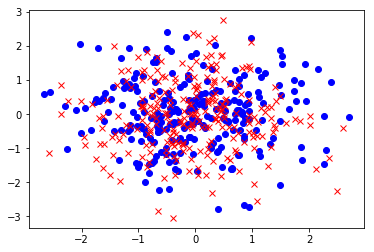

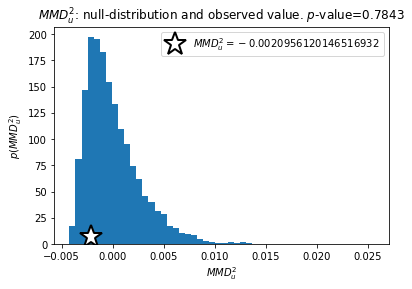

In [54]:
main_test_different_setting ( )

In [51]:
def main_test_different_setting( ): 
    import matplotlib.pyplot as plt
    from sklearn.metrics import pairwise_distances

    np.random.seed(0)
    print ( "w" )
     
    m = 20
    n = 20
    d = 2

    m = 250
    n = 250

    sigma2X = np.eye(d)
    muX = np.zeros(d)

    sigma2Y = np.eye(d)
    #muY = np.ones(d)
    muY = np.zeros(d)

    #iterations = 10000
    iterations = 10000
      
    X = np.random.multivariate_normal(mean=muX, cov=sigma2X, size=m)
    Y = np.random.multivariate_normal(mean=muY, cov=sigma2Y, size=n)
    print (X.shape) 
    print(Y.shape)

     
    if d == 2:
        plt.figure()
        plt.plot(X[:, 0], X[:, 1], 'bo')
        plt.plot(Y[:, 0], Y[:, 1], 'rx')
        #plt.show()
      

    sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
    print(sigma2)
      
    mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
                                                        kernel_function='rbf',
                                                        gamma=1.0/sigma2,
                                                        iterations=iterations,
                                                        verbose=True)
    # mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
    #                                                     kernel_function='linear',
    #                                                     verbose=True)

    plt.figure()
    prob, bins, patches = plt.hist(mmd2u_null, bins=50, normed=True)
    plt.plot(mmd2u, prob.max()/30, 'w*', markersize=24, markeredgecolor='k',
             markeredgewidth=2, label="$MMD^2_u = %s$" % mmd2u)
    plt.xlabel('$MMD^2_u$')
    plt.ylabel('$p(MMD^2_u)$')
    plt.legend(numpoints=1)
    plt.title('$MMD^2_u$: null-distribution and observed value. $p$-value=%s'
              % p_value)
    plt.show()


